# 설정

In [ ]:
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!sudo apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/DATA304'

/content/drive/MyDrive/DATA304


In [ ]:
import pandas as pd

phone_data = pd.read_csv('phone_data.csv')
phone_data.head()

,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


# 텍스트 규칙 기반 레이블 지정


In [ ]:
import re

updated_patterns = {
    1: r"흠집 없음|배터리 상태 좋음|새상품|미사용|완벽한 상태|아주 좋은 상태|최상|A급|완전 새것|새 것 같은|거의 새것",
    2: r"사용감 조금|흠집 몇 개|좋은 상태|사용감 적음|양호한 상태|B급|관리 잘 됨|사용감 약간|약간의 기스",
    3: r"보통 상태|사용감 있음|흠집 있음|정상 작동|소모품 교체|C급|평균적인 상태|일반 사용감|통상적인 사용감",
    4: r"액정 파손|사용에 불편함|부분적 고장|수리 필요|작동에 문제|D급|약간의 고장|일부 기능 이상|사용에 지장",
    5: r"매우 나쁨|고장|작동하지 않음|부품 누락|심각한 손상|E급|심각한 결함|많은 손상|고장남|수리 불가"
}

def assign_label_with_updated_patterns(text):
    for label, pattern in updated_patterns.items():
        if re.search(pattern, text):
            return label
    return None

phone_data['label'] = phone_data['text'].apply(assign_label_with_updated_patterns)

nan_count = phone_data['label'].isna().sum()
nan_count, phone_data.head()

(4146,
                create_date     price  \
 0   2017-03-19  4 35 00 PM  550000.0   
 1  2016-10-26  12 08 00 PM  380000.0   
 2  2016-10-25  12 52 00 PM  300000.0   
 3  2017-03-23  11 14 00 PM  290000.0   
 4   2016-04-11  7 35 00 PM  280000.0   
 
                                                 text          phone_model  \
 0  아이폰6플러스 블랙+애플라이트 64기가 팝니다  아이폰6플러스 블랙+애플라이트 64...        iphone 6 64gb   
 1  갤럭시s6엣지 32기가 팝니다 직거래  갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...  galaxy s6 edge 32gb   
 2  갤럭시s6 풀박스로 팝니다~~~ 새상품급  실기스조차 없어요  직접거래 구매한지 1...       galaxy s6 32gb   
 3  sk  g5 티탄 폰 단품판매합니다  직접거래 sk g5 티탄 폰 단품판매합니다 올...           lg g5 32gb   
 4   sony 엑스페리아 c5 ultra e5506 16gb  미사용 새제품 팝니다 1...            lg u 32gb   
 
    factory_price    maker  price_index  label  
 0         924000    apple        95.96    NaN  
 1         979000  samsung       103.05    NaN  
 2         854000  samsung       103.05    1.0  
 3         836000       lg        95.96    NaN  
 4         396000       lg    

In [ ]:
print(phone_data['label'].value_counts())

1.0    605
5.0    100
3.0     49
2.0     30
4.0     21
Name: label, dtype: int64


# GCN 기반 레이블 지정

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check if CUDA is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# TF-IDF 기반 텍스트 유사도 계산
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(phone_data['text'])
cosine_sim = cosine_similarity(tfidf_matrix)

In [ ]:
# 노드 생성 및 노드 특성 할당
G = nx.Graph()

for i, row in phone_data.iterrows():
    feature = np.array([row['price'], row['factory_price'], row['price_index']])
    label = row['label'] if pd.notnull(row['label']) else -1  # 레이블 할당 (-1은 레이블 없음)
    G.add_node(i, feature=feature, label=label)

# 유사도에 따른 엣지 생성
threshold = 0.5  # 유사도 임계값
for i in range(cosine_sim.shape[0]):
    for j in range(i + 1, cosine_sim.shape[1]):
        if cosine_sim[i, j] > threshold:
            G.add_edge(i, j)

# PyTorch Geometric 데이터로 변환
x = torch.tensor([G.nodes[node]['feature'] for node in G.nodes], dtype=torch.float)
y = torch.tensor([G.nodes[node]['label'] for node in G.nodes], dtype=torch.long)

# 그래프의 엣지 리스트를 PyTorch Geometric 형식으로 변환
edge_index = torch.tensor([[u, v] for u, v in G.edges()], dtype=torch.long).t().contiguous()

# PyTorch Geometric 데이터 객체 생성
data = Data(x=x, edge_index=edge_index, y=y).to(device)

In [ ]:
print(data)

Data(x=[4951, 3], edge_index=[2, 5970], y=[4951])


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.bn1 = torch.nn.BatchNorm1d(16)
        self.conv2 = GCNConv(16, num_classes)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 16, dropout=0.5)
        self.conv2 = GATConv(16, num_classes, dropout=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
from torch_geometric.nn import GCNConv, JumpingKnowledge

class JKNet(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(JKNet, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.bn1 = torch.nn.BatchNorm1d(16)
        self.conv2 = GCNConv(16, 16)
        self.bn2 = torch.nn.BatchNorm1d(16)
        self.conv3 = GCNConv(16, 16)
        self.bn3 = torch.nn.BatchNorm1d(16)
        self.conv4 = GCNConv(16, 16)
        self.bn4 = torch.nn.BatchNorm1d(16)
        self.conv5 = GCNConv(16, 16)
        self.bn5 = torch.nn.BatchNorm1d(16)
        self.conv6 = GCNConv(16, 16)
        self.bn6 = torch.nn.BatchNorm1d(16)

        self.jk = JumpingKnowledge(mode='cat')
        self.fc = torch.nn.Linear(16 * 6, num_classes)  # 6 layers x 16 features each

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x1 = F.relu(self.bn1(self.conv1(x, edge_index)))
        x2 = F.relu(self.bn2(self.conv2(x1, edge_index)))
        x3 = F.relu(self.bn3(self.conv3(x2, edge_index)))
        x4 = F.relu(self.bn4(self.conv4(x3, edge_index)))
        x5 = F.relu(self.bn5(self.conv5(x4, edge_index)))
        x6 = F.relu(self.bn6(self.conv6(x5, edge_index)))

        x_all = self.jk([x1, x2, x3, x4, x5, x6])
        x_all = F.dropout(x_all, p=0.5, training=self.training)
        x_all = self.fc(x_all)

        return F.log_softmax(x_all, dim=1)

In [ ]:
import torch
import numpy as np

# 모델 초기화
model = JKNet(num_features=3, num_classes=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# 훈련 중 성능 지표를 저장할 리스트 초기화
losses = []
accuracies = []
f1_scores = []

# 레이블당 샘플 수
samples_per_label = 21

# 각 레이블에 대한 노드 인덱스 선택
selected_indices = []
for label in range(1, 6):  # 1, 2, 3, 4, 5번 레이블에 대해
    label_indices = (y == label).nonzero().view(-1)
    selected_indices.extend(label_indices[torch.randperm(len(label_indices))[:samples_per_label]].cpu().numpy())

# 선택된 노드 인덱스를 이용한 train_mask 생성
balanced_train_mask = torch.zeros_like(y, dtype=torch.bool)
balanced_train_mask[torch.tensor(selected_indices)] = True
balanced_train_mask = balanced_train_mask.to(device)

# y 텐서를 GPU로 이동
y = y.to(device)

# 훈련 과정
for epoch in range(10000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[balanced_train_mask], y[balanced_train_mask])
    loss.backward()
    optimizer.step()

    # 성능 평가
    if epoch % 50 == 0:
        model.eval()
        with torch.no_grad():
            preds = out.argmax(dim=1)
            accuracy = accuracy_score(y.cpu()[balanced_train_mask.cpu()].numpy(), preds.cpu()[balanced_train_mask.cpu()].numpy())
            f1 = f1_score(y.cpu()[balanced_train_mask.cpu()], preds.cpu()[balanced_train_mask.cpu()], average='weighted')

            print(f'Epoch {epoch}, Loss: {round(loss.item(), 4)}, Accuracy: {round(accuracy, 4)}, F1 Score: {round(f1, 4)}')

        # 성능 지표 저장
        losses.append(loss.item())
        accuracies.append(accuracy)
        f1_scores.append(f1)

Epoch 0, Loss: 1.7858, Accuracy: 0.1524, F1 Score: 0.1596
Epoch 50, Loss: 0.9092, Accuracy: 0.6286, F1 Score: 0.6247
Epoch 100, Loss: 0.7596, Accuracy: 0.619, F1 Score: 0.6179
Epoch 150, Loss: 0.6071, Accuracy: 0.7429, F1 Score: 0.7484
Epoch 200, Loss: 0.5927, Accuracy: 0.781, F1 Score: 0.7791
Epoch 250, Loss: 0.5552, Accuracy: 0.7619, F1 Score: 0.7624
Epoch 300, Loss: 0.6162, Accuracy: 0.7619, F1 Score: 0.7621
Epoch 350, Loss: 0.3608, Accuracy: 0.8571, F1 Score: 0.8578
Epoch 400, Loss: 0.3761, Accuracy: 0.8476, F1 Score: 0.8481
Epoch 450, Loss: 0.4867, Accuracy: 0.8095, F1 Score: 0.8094
Epoch 500, Loss: 0.3897, Accuracy: 0.8476, F1 Score: 0.8486
Epoch 550, Loss: 0.3837, Accuracy: 0.8381, F1 Score: 0.8387
Epoch 600, Loss: 0.4245, Accuracy: 0.819, F1 Score: 0.8201
Epoch 650, Loss: 0.3711, Accuracy: 0.8476, F1 Score: 0.8474
Epoch 700, Loss: 0.3263, Accuracy: 0.819, F1 Score: 0.8186
Epoch 750, Loss: 0.3399, Accuracy: 0.8762, F1 Score: 0.8742
Epoch 800, Loss: 0.3221, Accuracy: 0.8667, F1 S

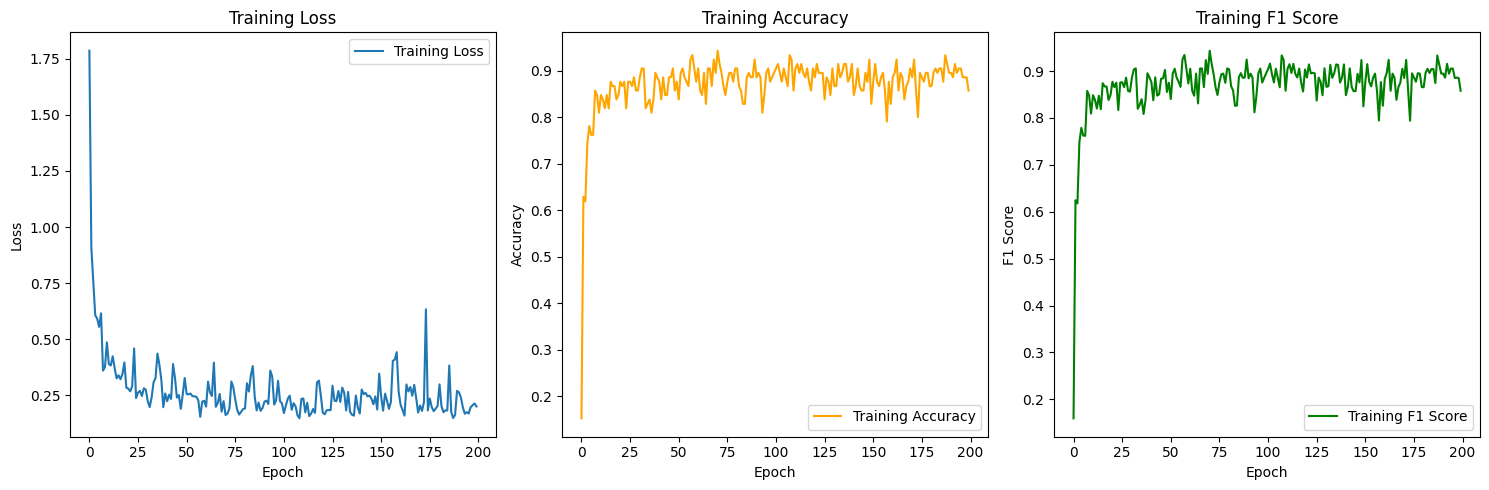

In [ ]:
import matplotlib.pyplot as plt

# 성능 지표 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loss 그래프
axes[0].plot(losses, label='Training Loss')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy 그래프
axes[1].plot(accuracies, label='Training Accuracy', color='orange')
axes[1].set_title('Training Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# F1 Score 그래프
axes[2].plot(f1_scores, label='Training F1 Score', color='green')
axes[2].set_title('Training F1 Score')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
# 균형 잡힌 테스트 샘플링
balanced_test_indices = []
for label in range(1, 6):  # 1, 2, 3, 4, 5번 레이블에 대해
    label_indices = (y == label).nonzero().view(-1)
    balanced_test_indices.extend(label_indices[torch.randperm(len(label_indices))[:samples_per_label]].cpu().numpy())

balanced_test_mask = torch.zeros_like(y, dtype=torch.bool)
balanced_test_mask[torch.tensor(balanced_test_indices)] = True
balanced_test_mask = balanced_test_mask.to(device)

# 최종 평가
model.eval()
with torch.no_grad():
    out = model(data)
    preds = out.argmax(dim=1)
    final_accuracy = accuracy_score(y.cpu()[balanced_test_mask.cpu()].numpy(), preds.cpu()[balanced_test_mask.cpu()].numpy())
    final_f1 = f1_score(y.cpu()[balanced_test_mask.cpu()], preds.cpu()[balanced_test_mask.cpu()], average='weighted')

print(f'Final Accuracy: {round(final_accuracy, 4)}, Final F1 Score: {round(final_f1, 4)}')

# 예측 레이블을 데이터 프레임에 추가
phone_data['predicted_label'] = preds.cpu().numpy()

Final Accuracy: 0.6571, Final F1 Score: 0.655


In [ ]:
phone_data['label'] = phone_data.apply(lambda row: row['predicted_label'] if pd.isna(row['label']) else row['label'], axis=1)
phone_data.drop(columns=['predicted_label'], inplace=True)
phone_data.to_csv('phone_data_with_labels.csv', index=False, encoding='utf-8-sig')

In [ ]:
phone_data['label'].value_counts()

1.0    1878
5.0     948
2.0     942
3.0     613
4.0     570
Name: label, dtype: int64

# 레이블 예측 (텍스트 포함)

In [ ]:
import pandas as pd

df = pd.read_csv('phone_data_with_labels.csv')
df.head()

,create_date,price,text,phone_model,factory_price,maker,price_index,label
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96,1.0
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05,2.0
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05,1.0
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96,5.0
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59,1.0


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# 1. 결측값 처리
df = df.dropna()  # 결측값이 있는 행 제거

# 2. 'create_date' 처리
df['create_date'] = pd.to_datetime(df['create_date'], format='%Y-%m-%d %I %M %S %p')
df['year'] = df['create_date'].dt.year
df['month'] = df['create_date'].dt.month
df['day'] = df['create_date'].dt.day
df['hour'] = df['create_date'].dt.hour
df['minute'] = df['create_date'].dt.minute

# 3. 'text' 처리
tfidf = TfidfVectorizer(max_features=100)  # 예시로 100개의 feature만 사용
text_features = tfidf.fit_transform(df['text']).toarray()
text_features_df = pd.DataFrame(text_features, columns=[f'text_{i}' for i in range(text_features.shape[1])])
df = pd.concat([df, text_features_df], axis=1)

# 4. 'phone_model', 'maker' 처리
encoder = LabelEncoder()
df['phone_model_encoded'] = encoder.fit_transform(df['phone_model'])
df['maker_encoded'] = encoder.fit_transform(df['maker'])

# 5. 수치형 데이터 처리
scaler = StandardScaler()
df[['price', 'factory_price', 'price_index']] = scaler.fit_transform(df[['price', 'factory_price', 'price_index']])

# 6. 필요없는 컬럼 제거
df = df.drop(['create_date', 'text', 'phone_model', 'maker'], axis=1)

# 데이터 분리
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Logistic Regression
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=5, verbose=3)
lr_grid.fit(X_train, y_train)
print("Best parameters for Logistic Regression: ", lr_grid.best_params_)
print("Classification Report (Logistic Regression):\n", classification_report(y_test, lr_grid.predict(X_test)))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........................C=0.001;, score=0.390 total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........................C=0.001;, score=0.381 total time=   4.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...........................C=0.001;, score=0.376 total time=   5.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........................C=0.001;, score=0.403 total time=   2.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........................C=0.001;, score=0.385 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................C=0.01;, score=0.420 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................C=0.01;, score=0.398 total time=   5.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................C=0.01;, score=0.393 total time=   6.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................C=0.01;, score=0.423 total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................C=0.01;, score=0.374 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=0.1;, score=0.443 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=0.1;, score=0.427 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=0.1;, score=0.396 total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............................C=0.1;, score=0.417 total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .............................C=0.1;, score=0.403 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...............................C=1;, score=0.417 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...............................C=1;, score=0.410 total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...............................C=1;, score=0.396 total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...............................C=1;, score=0.432 total time=   5.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...............................C=1;, score=0.369 total time=   4.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..............................C=10;, score=0.442 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..............................C=10;, score=0.395 total time=   4.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..............................C=10;, score=0.389 total time=   3.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..............................C=10;, score=0.429 total time=   5.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..............................C=10;, score=0.412 total time=   4.4s
Best parameters for Logistic Regression:  {'C': 0.1}
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

         1.0       0.43      0.67      0.53       382
         2.0       0.42      0.44      0.43       183
         3.0       0.33      0.15      0.21       118
         4.0       0.30      0.16      0.21       116
         5.0       0.19      0.08      0.12       192

    accuracy                           0.39       991
   macro avg       0.33      0.30      0.30       991
weighted avg       0.35      0.39      0.35       991



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Support Vector Machine
svm_params = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
svm_grid = GridSearchCV(SVC(), svm_params, cv=5, verbose=3)
svm_grid.fit(X_train, y_train)
print("Best parameters for SVM: ", svm_grid.best_params_)
print("Classification Report (SVM):\n", classification_report(y_test, svm_grid.predict(X_test)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.379 total time=   2.8s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.378 total time=   2.8s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.378 total time=   3.4s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.378 total time=   3.5s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.378 total time=   3.1s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.379 total time=   2.2s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.378 total time=   2.2s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.378 total time=   2.2s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.378 total time=   2.2s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.378 total time=   3.0s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.380 total time=   2.5s
[CV 2/5] END .................C=0.1, gamma=0.01;

In [ ]:
# Random Forest
rf_params = {'n_estimators': [100, 200, 500], 'max_features': ['auto', 'sqrt', 'log2']}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
rf_grid.fit(X_train, y_train)
print("Best parameters for Random Forest: ", rf_grid.best_params_)
print("Classification Report (Random Forest):\n", classification_report(y_test, rf_grid.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best parameters for Random Forest:  {'max_features': 'auto', 'n_estimators': 500}
Classification Report (Random Forest):
               precision    recall  f1-score   support

         1.0       0.68      0.80      0.73       382
         2.0       0.70      0.66      0.68       183
         3.0       0.68      0.49      0.57       118
         4.0       0.51      0.48      0.50       116
         5.0       0.57      0.51      0.54       192

    accuracy                           0.64       991
   macro avg       0.63      0.59      0.60       991
weighted avg       0.64      0.64      0.64       991



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPWithFeatures(nn.Module):
    def __init__(self, num_features, num_classes):
        super(MLPWithFeatures, self).__init__()

        # 입력 피처 개수와 출력 클래스 개수 설정
        self.num_features = num_features
        self.num_classes = num_classes

        # MLP의 hidden layer 크기 설정
        hidden_size = 128

        # 모델의 아키텍처 정의
        self.fc1 = nn.Linear(num_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # 배치 정규화
        self.dropout1 = nn.Dropout(0.5)         # 드롭아웃

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)  # 배치 정규화
        self.dropout2 = nn.Dropout(0.5)         # 드롭아웃

        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 입력 데이터를 MLP에 전달
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.fc3(x)

        # 출력값을 소프트맥스 함수로 변환하여 클래스 확률을 얻음
        return F.log_softmax(x, dim=1)

# 모델 생성 및 초기화
num_features = 110  # 입력 피처 개수 (예: 3개의 피처)
num_classes = 6  # 클래스 개수 (예: 6개의 클래스)
model = MLPWithFeatures(num_features, num_classes)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# 데이터 로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 생성
model = MLPWithFeatures(num_features, num_classes)

# 옵티마이저 및 손실 함수 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()  # Negative Log Likelihood Loss

In [ ]:
# 학습 함수 정의
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    predictions = []
    true_labels = []

    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 예측 결과 저장
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    return total_loss / len(train_loader), accuracy, f1

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_f1 = train(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f}")

Epoch 1/100: Train Loss: 1.8184, Train Accuracy: 0.2674, Train F1 Score: 0.2747
Epoch 2/100: Train Loss: 1.6406, Train Accuracy: 0.3424, Train F1 Score: 0.3133
Epoch 3/100: Train Loss: 1.5271, Train Accuracy: 0.3702, Train F1 Score: 0.3217
Epoch 4/100: Train Loss: 1.4615, Train Accuracy: 0.3899, Train F1 Score: 0.3435
Epoch 5/100: Train Loss: 1.4047, Train Accuracy: 0.4018, Train F1 Score: 0.3593
Epoch 6/100: Train Loss: 1.3706, Train Accuracy: 0.4111, Train F1 Score: 0.3747
Epoch 7/100: Train Loss: 1.3673, Train Accuracy: 0.4162, Train F1 Score: 0.3765
Epoch 8/100: Train Loss: 1.3501, Train Accuracy: 0.4280, Train F1 Score: 0.3949
Epoch 9/100: Train Loss: 1.3460, Train Accuracy: 0.4141, Train F1 Score: 0.3807
Epoch 10/100: Train Loss: 1.3265, Train Accuracy: 0.4341, Train F1 Score: 0.3987
Epoch 11/100: Train Loss: 1.3212, Train Accuracy: 0.4336, Train F1 Score: 0.3973
Epoch 12/100: Train Loss: 1.3124, Train Accuracy: 0.4467, Train F1 Score: 0.4167
Epoch 13/100: Train Loss: 1.3070, Tra

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def test(model, test_loader, device, y_test):
    model = model.to(device)  # Move model to the correct device
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Convert outputs to predictions
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, all_predictions)
    f1 = f1_score(y_test, all_predictions, average='weighted')

    return accuracy, f1

# Assuming X_test is your test data in DataFrame format and y_test is your test labels
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_accuracy, test_f1 = test(model, test_loader, device, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.3996, Test F1 Score: 0.3205


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, dim_feedforward=512, nhead=8, num_layers=3):
        super(SimpleTransformer, self).__init__()
        self.input_linear = nn.Linear(input_dim, dim_feedforward)

        transformer_layers = nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layers, num_layers=num_layers)

        self.output_linear = nn.Linear(dim_feedforward, num_classes)

    def forward(self, x):
        # Transform input to higher dimension
        x = self.input_linear(x)
        # Dummy batch dimension for transformer
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        # Classify output
        x = self.output_linear(x)
        return F.log_softmax(x, dim=1)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleTransformer(input_dim=110, num_classes=6).to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = accuracy_score(all_labels, all_predictions)
    epoch_f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}%, F1 Score: {epoch_f1:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 1.6597, Accuracy: 0.3328%, F1 Score: 0.2329
Epoch 2, Loss: 1.5530, Accuracy: 0.3677%, F1 Score: 0.2219
Epoch 3, Loss: 1.5330, Accuracy: 0.3735%, F1 Score: 0.2189
Epoch 4, Loss: 1.5328, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 5, Loss: 1.5244, Accuracy: 0.3795%, F1 Score: 0.2137
Epoch 6, Loss: 1.5212, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 7, Loss: 1.5214, Accuracy: 0.3775%, F1 Score: 0.2071
Epoch 8, Loss: 1.5277, Accuracy: 0.3775%, F1 Score: 0.2082
Epoch 9, Loss: 1.5216, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 10, Loss: 1.5172, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 11, Loss: 1.5212, Accuracy: 0.3775%, F1 Score: 0.2071
Epoch 12, Loss: 1.5161, Accuracy: 0.3775%, F1 Score: 0.2071
Epoch 13, Loss: 1.5146, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 14, Loss: 1.5133, Accuracy: 0.3773%, F1 Score: 0.2071
Epoch 15, Loss: 1.5149, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 16, Loss: 1.5136, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 17, Loss: 1.5126, Accuracy: 0.3778%, F1 Sco

In [ ]:
def test(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1

accuracy, f1 = test(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.4f}%, Test F1 Score: {f1:.4f}')

Test Accuracy: 0.3855%, Test F1 Score: 0.2145


# 레이블 예측 (텍스트 미포함)

In [3]:
import pandas as pd

df = pd.read_csv('phone_data_with_labels.csv')
df.head()

,create_date,price,text,phone_model,factory_price,maker,price_index,label
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96,1.0
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05,2.0
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05,1.0
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96,5.0
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59,1.0


In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# 1. 결측값 처리
df = df.dropna()  # 결측값이 있는 행 제거

# 2. 'create_date' 처리
df['create_date'] = pd.to_datetime(df['create_date'], format='%Y-%m-%d %I %M %S %p')
df['year'] = df['create_date'].dt.year
df['month'] = df['create_date'].dt.month
df['day'] = df['create_date'].dt.day
df['hour'] = df['create_date'].dt.hour
df['minute'] = df['create_date'].dt.minute

# 3. 'text' 처리
# tfidf = TfidfVectorizer(max_features=100)  # 예시로 100개의 feature만 사용
# text_features = tfidf.fit_transform(df['text']).toarray()
# text_features_df = pd.DataFrame(text_features, columns=[f'text_{i}' for i in range(text_features.shape[1])])
# df = pd.concat([df, text_features_df], axis=1)

# 4. 'phone_model', 'maker' 처리
encoder = LabelEncoder()
df['phone_model_encoded'] = encoder.fit_transform(df['phone_model'])
df['maker_encoded'] = encoder.fit_transform(df['maker'])

# 5. 수치형 데이터 처리
scaler = StandardScaler()
df[['price', 'factory_price', 'price_index']] = scaler.fit_transform(df[['price', 'factory_price', 'price_index']])

# 6. 필요없는 컬럼 제거
df = df.drop(['create_date', 'text', 'phone_model', 'maker'], axis=1)

# 데이터 분리
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Logistic Regression
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=5, verbose=3)
lr_grid.fit(X_train, y_train)
print("Best parameters for Logistic Regression: ", lr_grid.best_params_)
print("Classification Report (Logistic Regression):\n", classification_report(y_test, lr_grid.predict(X_test)))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........................C=0.001;, score=0.390 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........................C=0.001;, score=0.380 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...........................C=0.001;, score=0.374 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........................C=0.001;, score=0.402 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........................C=0.001;, score=0.385 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................C=0.01;, score=0.415 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................C=0.01;, score=0.413 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................C=0.01;, score=0.381 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................C=0.01;, score=0.422 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................C=0.01;, score=0.367 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=0.1;, score=0.423 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=0.1;, score=0.396 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=0.1;, score=0.386 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............................C=0.1;, score=0.424 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .............................C=0.1;, score=0.389 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...............................C=1;, score=0.408 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...............................C=1;, score=0.386 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...............................C=1;, score=0.385 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...............................C=1;, score=0.418 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...............................C=1;, score=0.390 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..............................C=10;, score=0.398 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..............................C=10;, score=0.398 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..............................C=10;, score=0.381 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..............................C=10;, score=0.412 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..............................C=10;, score=0.389 total time=   0.9s
Best parameters for Logistic Regression:  {'C': 0.1}
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

         1.0       0.42      0.71      0.53       382
         2.0       0.45      0.42      0.43       183
         3.0       0.33      0.11      0.17       118
         4.0       0.33      0.03      0.06       116
         5.0       0.17      0.11      0.13       192

    accuracy                           0.39       991
   macro avg       0.34      0.28      0.27       991
weighted avg       0.36      0.39      0.34       991



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
# Support Vector Machine
svm_params = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
svm_grid = GridSearchCV(SVC(), svm_params, cv=5, verbose=3)
svm_grid.fit(X_train, y_train)
print("Best parameters for SVM: ", svm_grid.best_params_)
print("Classification Report (SVM):\n", classification_report(y_test, svm_grid.predict(X_test)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.379 total time=   1.3s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.378 total time=   1.3s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.378 total time=   1.3s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.378 total time=   1.3s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.378 total time=   1.3s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.379 total time=   0.8s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.378 total time=   0.9s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.378 total time=   1.3s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.378 total time=   1.4s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.378 total time=   1.4s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.380 total time=   1.2s
[CV 2/5] END .................C=0.1, gamma=0.01;

In [8]:
# Random Forest
rf_params = {'n_estimators': [100, 200, 500], 'max_features': ['auto', 'sqrt', 'log2']}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
rf_grid.fit(X_train, y_train)
print("Best parameters for Random Forest: ", rf_grid.best_params_)
print("Classification Report (Random Forest):\n", classification_report(y_test, rf_grid.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best parameters for Random Forest:  {'max_features': 'log2', 'n_estimators': 500}
Classification Report (Random Forest):
               precision    recall  f1-score   support

         1.0       0.70      0.69      0.70       382
         2.0       0.65      0.63      0.64       183
         3.0       0.68      0.64      0.66       118
         4.0       0.62      0.73      0.67       116
         5.0       0.64      0.62      0.63       192

    accuracy                           0.67       991
   macro avg       0.66      0.66      0.66       991
weighted avg       0.67      0.67      0.67       991



In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPWithFeatures(nn.Module):
    def __init__(self, num_features, num_classes):
        super(MLPWithFeatures, self).__init__()

        # 입력 피처 개수와 출력 클래스 개수 설정
        self.num_features = num_features
        self.num_classes = num_classes

        # MLP의 hidden layer 크기 설정
        hidden_size = 128

        # 모델의 아키텍처 정의
        self.fc1 = nn.Linear(num_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # 배치 정규화
        self.dropout1 = nn.Dropout(0.5)         # 드롭아웃

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)  # 배치 정규화
        self.dropout2 = nn.Dropout(0.5)         # 드롭아웃

        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 입력 데이터를 MLP에 전달
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.fc3(x)

        # 출력값을 소프트맥스 함수로 변환하여 클래스 확률을 얻음
        return F.log_softmax(x, dim=1)

# 모델 생성 및 초기화
num_features = 10  # 입력 피처 개수 (예: 3개의 피처)
num_classes = 6  # 클래스 개수 (예: 6개의 클래스)
model = MLPWithFeatures(num_features, num_classes)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# 데이터 로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 생성
model = MLPWithFeatures(num_features, num_classes)

# 옵티마이저 및 손실 함수 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()  # Negative Log Likelihood Loss

In [14]:
# 학습 함수 정의
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    predictions = []
    true_labels = []

    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 예측 결과 저장
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    return total_loss / len(train_loader), accuracy, f1

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_f1 = train(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f}")

Epoch 1/100: Train Loss: 1.8424, Train Accuracy: 0.2343, Train F1 Score: 0.2496
Epoch 2/100: Train Loss: 1.6614, Train Accuracy: 0.3298, Train F1 Score: 0.3036
Epoch 3/100: Train Loss: 1.5676, Train Accuracy: 0.3679, Train F1 Score: 0.3166
Epoch 4/100: Train Loss: 1.5158, Train Accuracy: 0.3803, Train F1 Score: 0.3150
Epoch 5/100: Train Loss: 1.4860, Train Accuracy: 0.3848, Train F1 Score: 0.3083
Epoch 6/100: Train Loss: 1.4657, Train Accuracy: 0.3881, Train F1 Score: 0.3183
Epoch 7/100: Train Loss: 1.4410, Train Accuracy: 0.3967, Train F1 Score: 0.3215
Epoch 8/100: Train Loss: 1.4394, Train Accuracy: 0.3944, Train F1 Score: 0.3285
Epoch 9/100: Train Loss: 1.4112, Train Accuracy: 0.3899, Train F1 Score: 0.3316
Epoch 10/100: Train Loss: 1.3913, Train Accuracy: 0.4045, Train F1 Score: 0.3475
Epoch 11/100: Train Loss: 1.3858, Train Accuracy: 0.4005, Train F1 Score: 0.3426
Epoch 12/100: Train Loss: 1.3761, Train Accuracy: 0.4091, Train F1 Score: 0.3539
Epoch 13/100: Train Loss: 1.3687, Tra

In [15]:
from sklearn.metrics import accuracy_score, f1_score

def test(model, test_loader, device, y_test):
    model = model.to(device)  # Move model to the correct device
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Convert outputs to predictions
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, all_predictions)
    f1 = f1_score(y_test, all_predictions, average='weighted')

    return accuracy, f1

# Assuming X_test is your test data in DataFrame format and y_test is your test labels
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_accuracy, test_f1 = test(model, test_loader, device, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.2069, Test F1 Score: 0.0950


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, dim_feedforward=512, nhead=8, num_layers=3):
        super(SimpleTransformer, self).__init__()
        self.input_linear = nn.Linear(input_dim, dim_feedforward)

        transformer_layers = nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layers, num_layers=num_layers)

        self.output_linear = nn.Linear(dim_feedforward, num_classes)

    def forward(self, x):
        # Transform input to higher dimension
        x = self.input_linear(x)
        # Dummy batch dimension for transformer
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        # Classify output
        x = self.output_linear(x)
        return F.log_softmax(x, dim=1)

In [17]:
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleTransformer(input_dim=10, num_classes=6).to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = accuracy_score(all_labels, all_predictions)
    epoch_f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}%, F1 Score: {epoch_f1:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 1.6409, Accuracy: 0.3513%, F1 Score: 0.2354
Epoch 2, Loss: 1.5449, Accuracy: 0.3626%, F1 Score: 0.2200
Epoch 3, Loss: 1.5410, Accuracy: 0.3649%, F1 Score: 0.2207
Epoch 4, Loss: 1.5433, Accuracy: 0.3725%, F1 Score: 0.2077
Epoch 5, Loss: 1.5391, Accuracy: 0.3702%, F1 Score: 0.2150
Epoch 6, Loss: 1.5267, Accuracy: 0.3735%, F1 Score: 0.2122
Epoch 7, Loss: 1.5268, Accuracy: 0.3778%, F1 Score: 0.2087
Epoch 8, Loss: 1.5225, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 9, Loss: 1.5192, Accuracy: 0.3775%, F1 Score: 0.2071
Epoch 10, Loss: 1.5195, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 11, Loss: 1.5174, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 12, Loss: 1.5149, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 13, Loss: 1.5160, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 14, Loss: 1.5176, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 15, Loss: 1.5138, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 16, Loss: 1.5166, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 17, Loss: 1.5140, Accuracy: 0.3778%, F1 Sco

In [18]:
def test(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1

accuracy, f1 = test(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.4f}%, Test F1 Score: {f1:.4f}')

Test Accuracy: 0.3855%, Test F1 Score: 0.2145


# 레이블 예측 (텍스트 차원축소)

In [24]:
import pandas as pd

df = pd.read_csv('phone_data_with_labels.csv')
df.head()

,create_date,price,text,phone_model,factory_price,maker,price_index,label
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96,1.0
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05,2.0
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05,1.0
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96,5.0
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59,1.0


In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# 1. 결측값 처리
df = df.dropna()  # 결측값이 있는 행 제거

# 2. 'create_date' 처리
df['create_date'] = pd.to_datetime(df['create_date'], format='%Y-%m-%d %I %M %S %p')
df['year'] = df['create_date'].dt.year
df['month'] = df['create_date'].dt.month
df['day'] = df['create_date'].dt.day
df['hour'] = df['create_date'].dt.hour
df['minute'] = df['create_date'].dt.minute

# 3. 'text' 처리
tfidf = TfidfVectorizer(max_features=100)  # 예시로 100개의 feature만 사용
text_features = tfidf.fit_transform(df['text']).toarray()
text_features_df = pd.DataFrame(text_features, columns=[f'text_{i}' for i in range(text_features.shape[1])])
tsne = TSNE(n_components=2, random_state=42, verbose=2)  # 예시로 2차원으로 축소
text_features_tsne = tsne.fit_transform(text_features_df)
text_features_tsne_df = pd.DataFrame(text_features_tsne, columns=['tsne_1', 'tsne_2'])
df = pd.concat([df, text_features_tsne_df], axis=1)

# 4. 'phone_model', 'maker' 처리
encoder = LabelEncoder()
df['phone_model_encoded'] = encoder.fit_transform(df['phone_model'])
df['maker_encoded'] = encoder.fit_transform(df['maker'])

# 5. 수치형 데이터 처리
scaler = StandardScaler()
df[['price', 'factory_price', 'price_index']] = scaler.fit_transform(df[['price', 'factory_price', 'price_index']])

# 6. 필요없는 컬럼 제거
df = df.drop(['create_date', 'text', 'phone_model', 'maker'], axis=1)

# 데이터 분리
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4951 samples in 0.001s...
[t-SNE] Computed neighbors for 4951 samples in 0.794s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4951
[t-SNE] Computed conditional probabilities for sample 2000 / 4951
[t-SNE] Computed conditional probabilities for sample 3000 / 4951
[t-SNE] Computed conditional probabilities for sample 4000 / 4951
[t-SNE] Computed conditional probabilities for sample 4951 / 4951
[t-SNE] Mean sigma: 0.323199
[t-SNE] Computed conditional probabilities in 0.444s
[t-SNE] Iteration 50: error = 86.8055725, gradient norm = 0.0069596 (50 iterations in 8.720s)
[t-SNE] Iteration 100: error = 86.2738342, gradient norm = 0.0094730 (50 iterations in 3.625s)
[t-SNE] Iteration 150: error = 85.6224823, gradient norm = 0.0082195 (50 iterations in 1.885s)
[t-SNE] Iteration 200: error = 85.5423279, gradient norm = 0.0064449 (50 iterations in 1.645s)
[t-SNE] Iteration 250: error = 85.5460892, gradient norm = 0.0139072

In [29]:
# Logistic Regression
lr_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=5, verbose=3)
lr_grid.fit(X_train, y_train)
print("Best parameters for Logistic Regression: ", lr_grid.best_params_)
print("Classification Report (Logistic Regression):\n", classification_report(y_test, lr_grid.predict(X_test)))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...........................C=0.001;, score=0.394 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...........................C=0.001;, score=0.391 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...........................C=0.001;, score=0.396 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...........................C=0.001;, score=0.413 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...........................C=0.001;, score=0.378 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................C=0.01;, score=0.412 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ............................C=0.01;, score=0.412 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ............................C=0.01;, score=0.391 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................C=0.01;, score=0.418 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ............................C=0.01;, score=0.378 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .............................C=0.1;, score=0.410 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=0.1;, score=0.400 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .............................C=0.1;, score=0.390 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............................C=0.1;, score=0.413 total time=   1.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END .............................C=0.1;, score=0.381 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ...............................C=1;, score=0.404 total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ...............................C=1;, score=0.384 total time=   1.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ...............................C=1;, score=0.394 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ...............................C=1;, score=0.407 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ...............................C=1;, score=0.389 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..............................C=10;, score=0.419 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..............................C=10;, score=0.383 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END ..............................C=10;, score=0.394 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ..............................C=10;, score=0.410 total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END ..............................C=10;, score=0.375 total time=   1.2s
Best parameters for Logistic Regression:  {'C': 0.01}
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

         1.0       0.43      0.79      0.56       382
         2.0       0.47      0.44      0.45       183
         3.0       0.30      0.08      0.13       118
         4.0       0.23      0.03      0.05       116
         5.0       0.19      0.07      0.10       192

    accuracy                           0.41       991
   macro avg       0.32      0.28      0.26       991
weighted avg       0.35      0.41      0.34       991



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
# Support Vector Machine
svm_params = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
svm_grid = GridSearchCV(SVC(), svm_params, cv=5, verbose=3)
svm_grid.fit(X_train, y_train)
print("Best parameters for SVM: ", svm_grid.best_params_)
print("Classification Report (SVM):\n", classification_report(y_test, svm_grid.predict(X_test)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.379 total time=   1.7s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.378 total time=   2.3s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.378 total time=   2.0s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.378 total time=   1.7s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.378 total time=   0.9s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.379 total time=   1.3s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.378 total time=   1.3s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.378 total time=   1.3s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.378 total time=   1.3s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.378 total time=   1.4s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.379 total time=   1.4s
[CV 2/5] END .................C=0.1, gamma=0.01;

In [31]:
# Random Forest
rf_params = {'n_estimators': [100, 200, 500], 'max_features': ['auto', 'sqrt', 'log2']}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
rf_grid.fit(X_train, y_train)
print("Best parameters for Random Forest: ", rf_grid.best_params_)
print("Classification Report (Random Forest):\n", classification_report(y_test, rf_grid.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best parameters for Random Forest:  {'max_features': 'sqrt', 'n_estimators': 100}
Classification Report (Random Forest):
               precision    recall  f1-score   support

         1.0       0.69      0.72      0.71       382
         2.0       0.70      0.67      0.68       183
         3.0       0.66      0.62      0.64       118
         4.0       0.58      0.63      0.61       116
         5.0       0.66      0.62      0.64       192

    accuracy                           0.67       991
   macro avg       0.66      0.65      0.65       991
weighted avg       0.67      0.67      0.67       991



In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPWithFeatures(nn.Module):
    def __init__(self, num_features, num_classes):
        super(MLPWithFeatures, self).__init__()

        # 입력 피처 개수와 출력 클래스 개수 설정
        self.num_features = num_features
        self.num_classes = num_classes

        # MLP의 hidden layer 크기 설정
        hidden_size = 128

        # 모델의 아키텍처 정의
        self.fc1 = nn.Linear(num_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # 배치 정규화
        self.dropout1 = nn.Dropout(0.5)         # 드롭아웃

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)  # 배치 정규화
        self.dropout2 = nn.Dropout(0.5)         # 드롭아웃

        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 입력 데이터를 MLP에 전달
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.fc3(x)

        # 출력값을 소프트맥스 함수로 변환하여 클래스 확률을 얻음
        return F.log_softmax(x, dim=1)

# 모델 생성 및 초기화
num_features = 12  # 입력 피처 개수 (예: 3개의 피처)
num_classes = 6  # 클래스 개수 (예: 6개의 클래스)
model = MLPWithFeatures(num_features, num_classes)

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# 데이터 로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 모델 생성
model = MLPWithFeatures(num_features, num_classes)

# 옵티마이저 및 손실 함수 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()  # Negative Log Likelihood Loss

In [36]:
# 학습 함수 정의
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    predictions = []
    true_labels = []

    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 예측 결과 저장
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    return total_loss / len(train_loader), accuracy, f1

# 학습 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_f1 = train(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f}")

Epoch 1/100: Train Loss: 1.8127, Train Accuracy: 0.2548, Train F1 Score: 0.2633
Epoch 2/100: Train Loss: 1.6498, Train Accuracy: 0.3288, Train F1 Score: 0.2959
Epoch 3/100: Train Loss: 1.5674, Train Accuracy: 0.3513, Train F1 Score: 0.2926
Epoch 4/100: Train Loss: 1.5412, Train Accuracy: 0.3644, Train F1 Score: 0.2906
Epoch 5/100: Train Loss: 1.5055, Train Accuracy: 0.3712, Train F1 Score: 0.2875
Epoch 6/100: Train Loss: 1.4909, Train Accuracy: 0.3765, Train F1 Score: 0.2882
Epoch 7/100: Train Loss: 1.4901, Train Accuracy: 0.3758, Train F1 Score: 0.2897
Epoch 8/100: Train Loss: 1.4812, Train Accuracy: 0.3742, Train F1 Score: 0.2907
Epoch 9/100: Train Loss: 1.4761, Train Accuracy: 0.3803, Train F1 Score: 0.2856
Epoch 10/100: Train Loss: 1.4714, Train Accuracy: 0.3811, Train F1 Score: 0.2833
Epoch 11/100: Train Loss: 1.4526, Train Accuracy: 0.3902, Train F1 Score: 0.3086
Epoch 12/100: Train Loss: 1.4540, Train Accuracy: 0.3874, Train F1 Score: 0.3052
Epoch 13/100: Train Loss: 1.4473, Tra

In [37]:
from sklearn.metrics import accuracy_score, f1_score

def test(model, test_loader, device, y_test):
    model = model.to(device)  # Move model to the correct device
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Convert outputs to predictions
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test, all_predictions)
    f1 = f1_score(y_test, all_predictions, average='weighted')

    return accuracy, f1

# Assuming X_test is your test data in DataFrame format and y_test is your test labels
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_accuracy, test_f1 = test(model, test_loader, device, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.4238, Test F1 Score: 0.3166


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, dim_feedforward=512, nhead=8, num_layers=3):
        super(SimpleTransformer, self).__init__()
        self.input_linear = nn.Linear(input_dim, dim_feedforward)

        transformer_layers = nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layers, num_layers=num_layers)

        self.output_linear = nn.Linear(dim_feedforward, num_classes)

    def forward(self, x):
        # Transform input to higher dimension
        x = self.input_linear(x)
        # Dummy batch dimension for transformer
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        # Classify output
        x = self.output_linear(x)
        return F.log_softmax(x, dim=1)

In [39]:
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleTransformer(input_dim=12, num_classes=6).to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loss.backward()
        optimizer.step()

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = accuracy_score(all_labels, all_predictions)
    epoch_f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}%, F1 Score: {epoch_f1:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 1.6406, Accuracy: 0.3432%, F1 Score: 0.2414
Epoch 2, Loss: 1.5412, Accuracy: 0.3593%, F1 Score: 0.2239
Epoch 3, Loss: 1.5393, Accuracy: 0.3687%, F1 Score: 0.2210
Epoch 4, Loss: 1.5419, Accuracy: 0.3662%, F1 Score: 0.2274
Epoch 5, Loss: 1.5330, Accuracy: 0.3684%, F1 Score: 0.2228
Epoch 6, Loss: 1.5312, Accuracy: 0.3755%, F1 Score: 0.2095
Epoch 7, Loss: 1.5264, Accuracy: 0.3755%, F1 Score: 0.2106
Epoch 8, Loss: 1.5237, Accuracy: 0.3773%, F1 Score: 0.2085
Epoch 9, Loss: 1.5224, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 10, Loss: 1.5177, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 11, Loss: 1.5198, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 12, Loss: 1.5184, Accuracy: 0.3778%, F1 Score: 0.2076
Epoch 13, Loss: 1.5180, Accuracy: 0.3775%, F1 Score: 0.2071
Epoch 14, Loss: 1.5157, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 15, Loss: 1.5168, Accuracy: 0.3773%, F1 Score: 0.2070
Epoch 16, Loss: 1.5157, Accuracy: 0.3778%, F1 Score: 0.2072
Epoch 17, Loss: 1.5140, Accuracy: 0.3778%, F1 Sco

In [40]:
def test(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1

accuracy, f1 = test(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.4f}%, Test F1 Score: {f1:.4f}')

Test Accuracy: 0.3855%, Test F1 Score: 0.2145
